In [1]:
import os
import json
import re
import scipy.io as spio
import numpy as np
from bokeh.plotting import figure
import tifffile as tf
import seaborn as sns
%matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage.color
from json_tricks.np import dump, dumps, load, loads
from mat2py import loadmat
from skimage import color
import cPickle as pkl

import seaborn as sns
import pandas as pd
from scipy import stats

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [2]:
source = '/nas/volume1/2photon/projects'
experiment = 'gratings_phaseMod' #'retino_bar' #'gratings_phaseMod'
session = '20171009_CE059' #'20170902_CE054' #'20170825_CE055'
acquisition = 'FOV1_zoom3x' #'FOV1_zoom3x_run2' #'FOV1_planar'
functional_dir = 'functional'
acquisition_dir = os.path.join(source, experiment, session, acquisition)

analysis_id = 'analysis03'

In [3]:
acquisition_dir = os.path.join(source, experiment, session, acquisition)
figdir = os.path.join(acquisition_dir, 'figures', analysis_id)
if not os.path.exists(figdir):
    os.makedirs(figdir)
print "Saving figures to dir:", figdir

# Load reference info:
ref_json = 'reference_%s.json' % functional_dir 
with open(os.path.join(acquisition_dir, ref_json), 'r') as fr:
    ref = json.load(fr)

# Load SI meta data:
si_basepath = ref['raw_simeta_path'][0:-4]
simeta_json_path = '%s.json' % si_basepath
with open(simeta_json_path, 'r') as fs:
    simeta = json.load(fs)


Saving figures to dir: /nas/volume1/2photon/projects/gratings_phaseMod/20171009_CE059/FOV1_zoom3x/figures/analysis03


In [4]:
custom_mw = False
stim_on_sec = 2.0
iti_pre = 1.0
curr_slice_idx = 0
color_by_roi = True
cmaptype = 'rainbow'

In [5]:
# Get stim params:
if custom_mw is False:
    currfile='File001'
    # stim_on_sec = 2.
    # iti = 1. #4.
    nframes = int(simeta[currfile]['SI']['hFastZ']['numVolumes'])
    framerate = float(simeta[currfile]['SI']['hRoiManager']['scanFrameRate'])
    volumerate = float(simeta[currfile]['SI']['hRoiManager']['scanVolumeRate'])
    frames_tsecs = np.arange(0, nframes)*(1/volumerate)

    nframes_on = stim_on_sec * volumerate
    #nframes_off = vols_per_trial - nframes_on
    nframes_iti_pre = round(iti_pre * volumerate) 
    print nframes_on
    print nframes_iti_pre

89.4054
45.0


In [6]:
# Get ROIPARAMS:
roi_dir = os.path.join(ref['roi_dir'], ref['roi_id'][analysis_id]) #, 'ROIs')
roiparams = loadmat(os.path.join(roi_dir, 'roiparams.mat'))
if 'roiparams' in roiparams.keys():
    roiparams = roiparams['roiparams']
maskpaths = roiparams['maskpaths']
print maskpaths
if not isinstance(maskpaths, list):
    maskpaths = [maskpaths] #[str(i) for i in maskpaths]


# Check slices to see if maskpaths exist for all slices, or just a subset:
if 'sourceslices' in roiparams.keys():
    slices = roiparams['sourceslices']
else:
    slices = np.arange(1, len(maskpaths)+1) #range(len(maskpaths))
print "Found masks for slices:", slices
if isinstance(slices, int):
    slices = [slices]
if not isinstance(slices, list): # i.e., only 1 slice
    slices = [int(i) for i in slices]
    
# Load masks:
#print maskpaths
masks = dict(("Slice%02d" % int(slice_idx), dict()) for slice_idx in slices)
for sidx,maskpath in zip(sorted(slices), sorted(maskpaths, key=natural_keys)):
    slice_name = "Slice%02d" % int(sidx) #+1)
    print "Loading masks: %s..." % slice_name 
    tmpmasks = loadmat(maskpath)
    if 'masks' in tmpmasks.keys():
        tmpmasks = tmpmasks['masks']
    masks[slice_name]['nrois'] =  tmpmasks.shape[2]
    masks[slice_name]['masks'] = tmpmasks

# Get specified slice masks:
slice_names = sorted(masks.keys(), key=natural_keys)
print "SLICE NAMES:", slice_names
curr_slice_name = slice_names[curr_slice_idx]
currmasks = masks[curr_slice_name]['masks']
print currmasks.shape

nrois = masks[curr_slice_name]['nrois']
print "NROIS:", nrois

/nas/volume1/2photon/projects/gratings_phaseMod/20171009_CE059/FOV1_zoom3x/ROIs/manual2D_poly/masks/20171009_CE059_FOV1_zoom3x_Slice01_Channel01_masks.mat
Found masks for slices: 1
Loading masks: Slice01...
SLICE NAMES: ['Slice01']
(512, 512, 17)
NROIS: 17


In [7]:
# Get FILE ("tiff") list
#avg_dir = options.avg_dir
avg_dir = ref['average_source'][analysis_id]
average_source = 'Averaged_Slices_%s' % avg_dir
signal_channel = ref['signal_channel'][analysis_id] #int(options.selected_channel)
average_slice_dir = os.path.join(acquisition_dir, functional_dir, 'DATA', average_source, "Channel{:02d}".format(signal_channel))
file_names = [f for f in os.listdir(average_slice_dir) if '_vis' not in f]
print "File names:", file_names
nfiles = len(file_names)

# Get AVERAGE slices (for current file):
curr_file_idx = 1
curr_file_name = file_names[curr_file_idx]
#curr_file_name = file_names[ref['refidx']]
curr_slice_dir = os.path.join(average_slice_dir, curr_file_name)
slice_fns = sorted([f for f in os.listdir(curr_slice_dir) if f.endswith('.tif')], key=natural_keys)

# Get average slice image for current-file, current-slice:
curr_slice_fn = slice_fns[curr_slice_idx]
avg_tiff_path = os.path.join(curr_slice_dir, curr_slice_fn)
with tf.TiffFile(avg_tiff_path) as tif:
    avgimg = tif.asarray()

File names: [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010']


In [8]:
# Get PARADIGM INFO:
path_to_functional = os.path.join(acquisition_dir, functional_dir)
paradigm_dir = 'paradigm_files'
path_to_paradigm_files = os.path.join(path_to_functional, paradigm_dir)
#path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', roi_method, 'Parsed')
path_to_trace_structs = os.path.join(acquisition_dir, 'Traces', ref['trace_id'][analysis_id], 'Parsed')

# Load stim trace structs:
print "Loading parsed traces..."
currchannel = "Channel%02d" % int(signal_channel)
stimtrace_fns = os.listdir(path_to_trace_structs)
stimtrace_fns = sorted([f for f in stimtrace_fns if 'stimtraces' in f and currchannel in f and f.endswith('.pkl')], key=natural_keys)
if len(stimtrace_fns)==0:
    print "No stim traces found for Channel %i" % int(selected_channel)
stimtrace_fn = stimtrace_fns[curr_slice_idx]
with open(os.path.join(path_to_trace_structs, stimtrace_fn), 'rb') as f:
    stimtraces = pkl.load(f)


stimlist = sorted(stimtraces.keys(), key=natural_keys)
nstimuli = len(stimlist)

Loading parsed traces...


In [9]:
# Set colormap
colormap = plt.get_cmap(cmaptype)

if color_by_roi:
    colorvals = colormap(np.linspace(0, 1, nrois)) #get_spaced_colors(nrois)
else:
    colorvals = colormap(np.linspace(0, 1, nstimuli)) #get_spaced_colors(nstimuli)

colorvals255 = [c[0:-1]*255 for c in colorvals]

### Plot "tuning curves"

In [10]:
roi = 20
trial_alpha = 0.5
trial_width = 0.5

roi_list = list(np.arange(0, nrois))

In [11]:
calcs = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in roi_list)
dfstruct = dict((roi, dict((stim, dict()) for stim in stimlist)) for roi in roi_list)

In [12]:
print "STIMS:", stimlist
print "NROIs:", len(roi_list)

STIMS: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
NROIs: 17


<IPython.core.display.Javascript object>


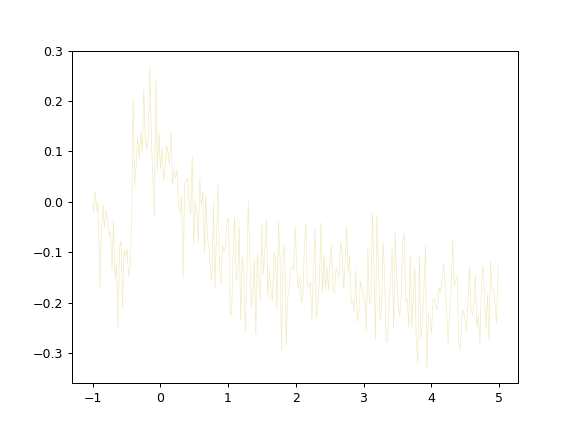

In [17]:
for roi in roi_list:
    for stimnum,stim in enumerate(stimlist):

        ntrialstmp = len(stimtraces[stim]['traces'])
        nframestmp = [stimtraces[stim]['traces'][i].shape[0] for i in range(len(stimtraces[stim]['traces']))]
        diffs = np.diff(nframestmp)
        if sum(diffs)>0:
            print "Incorrect frame nums per trial:", stimnum, stim
            print nframestmp
        else:
            nframestmp = nframestmp[0]

        raw = np.empty((ntrialstmp, nframestmp))
        for trialnum in range(ntrialstmp):
            raw[trialnum, :] = stimtraces[stim]['traces'][trialnum][0:nframestmp, roi].T

        ntrials = raw.shape[0]
        nframes_in_trial = raw.shape[1]

        xvals = np.empty((ntrials, nframes_in_trial))
        curr_dfs = np.empty((ntrials, nframes_in_trial))

        calcs[roi][stim] = dict()
        calcs[roi][stim]['zscores'] = []
        calcs[roi][stim]['mean_stim_on'] = []
        for trial in range(ntrials):
            if custom_mw is True:
                frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
                frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)
            else:
                frame_on = stimtraces[stim]['frames_stim_on'][trial][0]
                frame_on_idx = [i for i in stimtraces[stim]['frames'][trial]].index(frame_on)

            xvals[trial, :] = (stimtraces[stim]['frames'][trial] - frame_on) #+ stimnum*spacing
            baseline = np.mean(raw[trial, 0:frame_on_idx])


            df = (raw[trial,:] - baseline) / baseline
                    #print stim, trial
            curr_dfs[trial,:] = df

            stim_dur = stimtraces[stim]['frames_stim_on'][trial][1]-stimtraces[stim]['frames_stim_on'][trial][0]
            stim_interval = int(round(stim_dur))
            
            baseline_frames = curr_dfs[trial, 0:frame_on_idx]
            stim_frames = curr_dfs[trial, frame_on_idx:frame_on_idx+stim_interval]

            std_baseline = np.std(baseline_frames)
            mean_stim_on = np.mean(stim_frames)
            zval_trace = mean_stim_on / std_baseline

            calcs[roi][stim]['zscores'].append(zval_trace)
            calcs[roi][stim]['mean_stim_on'].append(mean_stim_on)
            calcs[roi][stim]['name'] = stimtraces[stim]['name']

            dfstruct[roi][stim]['name'] = stimtraces[stim]['name']
            dfstruct[roi][stim]['tsec'] = xvals/framerate
            dfstruct[roi][stim]['df'] = curr_dfs
            dfstruct[roi][stim]['frame_on'] = (frame_on_idx, frame_on)
            dfstruct[roi][stim]['baseline_vals'] = baseline_frames
            dfstruct[roi][stim]['stim_on_vals'] = stim_frames
            dfstruct[roi][stim]['stim_on_dur'] = stim_dur 

        #stats[roi][stim]['mean_stim_on'][trial] = mean_stim_on
        
plt.figure()
plt.plot(xvals[trial,:]/framerate, curr_dfs[trial,:], color=colorvals[stimnum], alpha=trial_alpha, linewidth=trial_width)
plt.show()

In [18]:
stiminfo = dict()
#print "STIM | ori - sf"
for stim in stimlist: #sorted(stimtraces.keys(), key=natural_keys):
    
    ori = stimtraces[stim]['name'].split('-')[2]
    sf = stimtraces[stim]['name'].split('-')[4]
    stiminfo[stim] = (int(ori), float(sf))
    print stim, ori, sf

oris = sorted(list(set([stiminfo[stim][0] for stim in stimlist]))) #, key=natural_keys)
sfs = sorted(list(set([stiminfo[stim][1] for stim in stimlist]))) #, key=natural_keys)
noris = len(oris)
nsfs = len(sfs)

stiminfo

1 0 0.100000
2 0 0.500000
3 30 0.100000
4 30 0.500000
5 60 0.100000
6 60 0.500000
7 90 0.100000
8 90 0.500000
9 120 0.100000
10 120 0.500000
11 150 0.100000
12 150 0.500000


{'1': (0, 0.1),
 '10': (120, 0.5),
 '11': (150, 0.1),
 '12': (150, 0.5),
 '2': (0, 0.5),
 '3': (30, 0.1),
 '4': (30, 0.5),
 '5': (60, 0.1),
 '6': (60, 0.5),
 '7': (90, 0.1),
 '8': (90, 0.5),
 '9': (120, 0.1)}

In [19]:
# stats[roi][stim]['zscores'].append(zval)
# stats[roi][stim]['mean_stim_on'].append(mean_stim_on)
# stats[roi][stim]['name'] = stimtraces[stim]['name']
trace_calcs = dict()

for roi in roi_list:
    std_zscores = np.zeros((nsfs, noris))
    sem_zscores = np.zeros((nsfs, noris))

    zscore_dfs = np.zeros((nsfs, noris))
    mean_dfs = np.zeros((nsfs, noris))
    spatialfreq = np.zeros((nsfs, noris))
    orientation = np.zeros((nsfs, noris))
    for si,spf in enumerate(sorted(sfs)):
        curr_sfs = [k for k in stiminfo.keys() if stiminfo[k][1]==spf]
        for oi,ori in enumerate(sorted(oris)):
            curr_ori = [k for k in curr_sfs if stiminfo[k][0]==ori][0]

            zscore_dfs[si, oi] = np.mean(calcs[roi][curr_ori]['zscores'])
            std_zscores[si, oi] = np.std(calcs[roi][curr_ori]['zscores'])
            sem_zscores[si, oi] = stats.sem(calcs[roi][curr_ori]['zscores'])

            mean_dfs[si, oi] = np.mean(calcs[roi][curr_ori]['mean_stim_on'])

            spatialfreq[si, oi] = spf
            orientation[si, oi] = int(ori)
            
    df = pd.DataFrame({'sf': spatialfreq.ravel(),
                   'ori': orientation.ravel(),
                   'zscore': zscore_dfs.ravel(),
                   'mean': mean_dfs.ravel(),
                   'std': std_zscores.ravel(),
                   'sem': sem_zscores.ravel()})
    
    trace_calcs[roi] = df
    


In [20]:
# df = pd.DataFrame({'sf': spatialfreq.ravel(),
#                    'ori': orientation.ravel(),
#                    'zscore': zscore_dfs.ravel(),
#                    'mean': mean_dfs.ravel(),
#                    'std': std_zscores.ravel(),
#                    'sem': sem_zscores.ravel()})
# print (df)

In [27]:
ROIs = list(np.arange(0, nrois))
ROIs = ROIs[0:-1]

In [33]:
nrows = int(np.ceil(np.sqrt(len(ROIs))))
ncols = int(np.ceil(len(ROIs)/float(nrows)))
print nrows, ncols

4 4


<IPython.core.display.Javascript object>


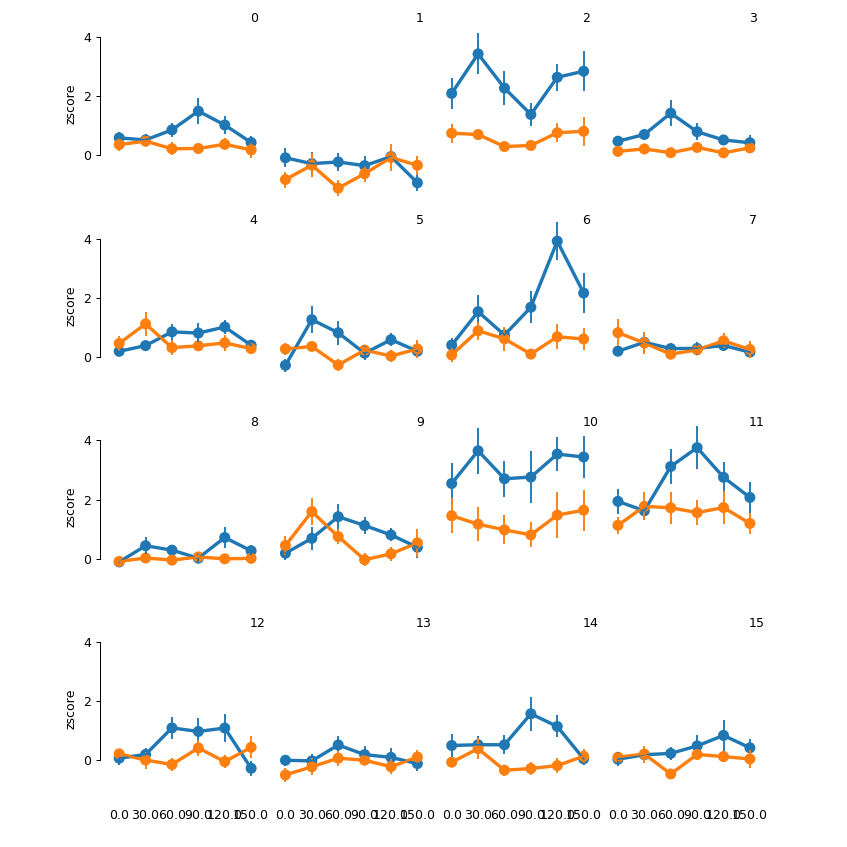

4 4
0 0 0
1 0 1
2 0 2
3 0 3
4 1 0
5 1 1
6 1 2
7 1 3
8 2 0
9 2 1
10 2 2
11 2 3
12 3 0
13 3 1
14 3 2
15 3 3


In [110]:
#plt.figure(figsize=(nrows, ncols))
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
def get_axis_limits(ax, scale=(0.9, 0.9)):
    return ax.get_xlim()[1]*scale[0], ax.get_ylim()[1]*scale[1]

#fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True)


ori_names = [str(int(i)) for i in oris]
# get the tick label font size
fontsize_pt = 8 #float(plt.rcParams['ytick.labelsize'])
dpi = 72.27
spacer = 20

# comput the matrix height in points and inches
matrix_height_pt = fontsize_pt * nrows * spacer
matrix_height_in = matrix_height_pt / dpi

# compute the required figure height 
top_margin = 0.01  # in percentage of the figure height
bottom_margin = 0.05 # in percentage of the figure height
figure_height = matrix_height_in / (1 - top_margin - bottom_margin)


# build the figure instance with the desired height
fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        sharex=True,
        sharey=True,
        figsize=(figure_height,figure_height), 
        gridspec_kw=dict(top=1-top_margin, bottom=bottom_margin, wspace=0.05, hspace=0.05))

row=0
col=0
print nrows, ncols
for roi in sorted(ROIs): #ROIs:
#     row = roi // nrows
#     col = roi % ncols
    if col==(ncols):
        row += 1
        col = 0
        
    print roi, row, col
    
    ax_curr = axs[row, col] #, col]
    
    df = trace_calcs[roi]
    #print df
    
    sf1 = df['sf']==sfs[0]
    sf2 = df['sf']==sfs[1]
    
    sns.pointplot(x="ori", y="zscore", hue="sf", data=df, ci='sd', ax=ax_curr)

    ax_curr.errorbar(np.arange(0,noris), df[sf1]['zscore'], yerr=df[sf1]['sem'])
    ax_curr.errorbar(np.arange(0,noris), df[sf2]['zscore'], yerr=df[sf2]['sem'])
    ax_curr.set_xlabel('')
    ax_curr.set_ylim([-1.5, 5])

    ax_curr.tick_params(axis=u'x', which=u'both',length=0)
    if col>0 and row<(nrows-1):
        ax_curr.set_ylabel('')
        ax_curr.tick_params(axis='y', which=u'both',length=0)
        sns.despine(left=True, bottom=True, right=True, ax=ax_curr, trim=True)
    elif col>0 and row==(nrows-1):

        ax_curr.set_ylabel('')
        ax_curr.tick_params(axis='y', which=u'both',length=0)
        ax_curr.tick_params(axis='x', which=u'both',length=0)
        sns.despine(left=True, right=True, bottom=True, offset=5, trim=True, ax=ax_curr)
    else:
        ax_curr.xaxis.set_major_locator(MaxNLocator(noris, integer=True))
        ax_curr.tick_params(axis='x', which=u'both',length=0)
        ax_curr.yaxis.set_major_locator(MaxNLocator(5, integer=True))
        #ax_curr.xaxis.set_major_locator(MaxNLocator(noris, integer=True))
        sns.despine(bottom=True, right=True, offset=5, trim=True, ax=ax_curr)

    ax_curr.annotate(str(roi), xy=get_axis_limits(ax_curr))
    ax_curr.legend().set_visible(False)

    col = col + 1

# ncols_left = ncols - col
# print "left", ncols_left
# for i in range(ncols_left):
#     axs[row, col+i].axis('off')

# sns.despine(offset=5, trim=True)

#fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


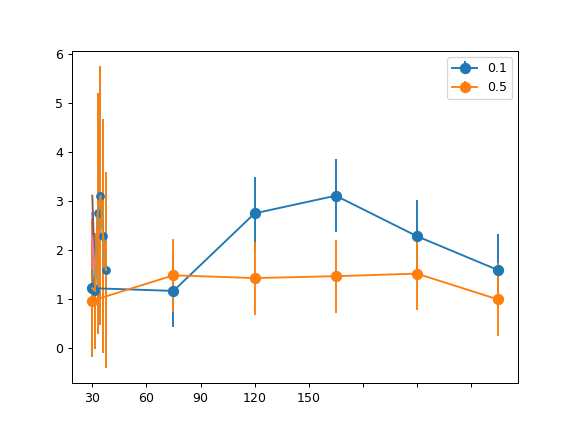

In [242]:
# plt.figure()
# plt.plot(range(noris), zscores[0, :])
# plt.plot(range(noris), zscores[1, :])

f, ax = plt.subplots(1, 1)
x_col='oris'
y_col = 'zscores'

# ax.plot(sf1.oris, sf1["zscores"], color="blue", label="A", linestyle="-")
# ax.plot(sf2.oris, sf2["zscores"], color="red", label="B", linestyle="-")

# # Add std deviation bars to the previous plot
sf1_err = np.std(sf1["zscores"])
sf2_err = np.std(sf2["zscores"])

(_, caps, _) = plt.errorbar(sf1.oris, sf1["zscores"], yerr=sf1_err, fmt='o-', markersize=8, capsize=0, label='0.1')
(_, caps, _) = plt.errorbar(sf2.oris, sf2["zscores"], yerr=sf1_err, fmt='o-', markersize=8, capsize=0, label='0.5')

for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend()

ax.set_xticklabels(sf1["oris"])
                   
plt.show()


# sns.pointplot(x="class", y="survived", hue="sex", data=titanic,
#               palette={"male": "g", "female": "m"},
#               markers=["^", "o"], linestyles=["-", "--"]);

In [174]:
sf1

,oris,zscores
0,0,1.219356
1,30,1.164328
2,60,2.748281
3,90,3.109420
4,120,2.281707
5,150,1.589109


In [149]:
stats[roi][stim]['zscores']

[0.58726824125457355,
 3.9959457023891245,
 0.72092876702079356,
 0.56735808086989992,
 0.24956109806018634,
 -0.2562866637203714,
 2.869069323905256,
 1.2484690538884717,
 3.6087549286450411,
 1.7627524198646947,
 -0.016254330276505864,
 3.1731095134646137,
 0.14129765030915131,
 1.7619723974390487,
 0.51946340727000206,
 0.3690379025161693,
 -0.13113135378710039,
 -0.019103052484243328,
 -0.58929942443085692,
 -0.77735353903490101]

In [28]:
stimtraces[stim]['name']

u'grating-ori-0-sf-0.100000'

In [35]:
stimtraces[stim]['frames_stim_on']

[[2336, 2425.4054],
 [5296, 5385.4054],
 [3143, 3232.4054],
 [3412, 3501.4054],
 [183, 272.4054],
 [2874, 2963.4054],
 [5834, 5923.4054],
 [6372, 6461.4054],
 [183, 272.4054],
 [4219, 4308.4054],
 [990, 1079.4054],
 [1259, 1348.4054],
 [3682, 3771.4054],
 [4220, 4309.4054],
 [3681, 3770.4054],
 [4488, 4577.4054],
 [3950, 4039.4054],
 [5564, 5653.4054],
 [183, 272.4054],
 [5296, 5385.4054]]

In [267]:
print nsfs
print noris

# Make a 2x6 matrix
cols = dict()
for idx,ori in enumerate(sorted(oris)):
    cols[ori] = idx

print cols

rows = dict()
for idx,sf in enumerate(sorted(sfs)):
    rows[sf] = idx
    
print rows



x = noris
y = nsfs

Z = np.zeros((y, x))
M = np.zeros((y, x))
for stim in sorted(calcs[roi].keys(), key=natural_keys):
    i = rows[stiminfo[stim][1]]

    j = cols[stiminfo[stim][0]] #+ j*(noris)
    
    #print i, j
    Z[i, j] = np.mean(calcs[roi][stim]['zscores'])
    M[i, j] = np.mean(calcs[roi][stim]['mean_stim_on'])
    
colormap = 'hot'
plt.figure() #figsize=(10,10))
plt.subplot(1,2,1)
plt.title('mean df/f')
ax = plt.gca()
im = ax.imshow(M, cmap=colormap) #(Y, X, Z)
plt.axis('off')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
    
    
plt.subplot(1,2,2)
plt.title('z-scored df/f')
ax = plt.gca()
im = ax.imshow(Z, cmap=colormap) #(Y, X, Z)
plt.axis('off')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

2
6
{0: 0, 150: 5, 120: 4, 90: 3, 60: 2, 30: 1}
{0.5: 1, 0.1: 0}
